In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 34.5 MB/s 
     |████████████████████████████████| 6.5 MB 19.9 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 895 kB 16.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 134 kB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.3 MB/s 
     |████████████████████████████████| 212 kB 41.7 MB/s 
     |████████████████████████████████| 127 kB 42.2 MB/s 
     |████████████████████████████████| 144 kB 23.6 MB/s 
     |████████████████████████████████| 271 kB 43.2 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy as np
import os
from keras.models import load_model
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import TFBertModel

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/IT350/datasets/mqp/mqp.csv',names=['docID','question1','question2','label'],header=None)
#df["label"] = df["label"].astype(str).astype(int)
del df["docID"]
df

,question1,question2,label
0,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1
3,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or v...,0
4,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache wi...,0
...,...,...,...
3043,15 million sperm can be a father?,My sperm count is 15 millions and is there a c...,1
3044,26 yo m with history of progressive venous ins...,"Hello doctor, can you please tell me some of t...",0
3045,26 yo m with history of progressive venous ins...,"Hello doctor, I am 26 year old male wth progre...",1
3046,32 weeks pregnant. Headache strange leg weakne...,I am 32 weeks pregnant and had severe headache...,0


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.20)
train.to_csv('/content/drive/MyDrive/IT350/datasets/mqp/train.csv',index=False)
test.to_csv('/content/drive/MyDrive/IT350/datasets/mqp/test.csv',index=False)

In [ ]:
from datasets import load_dataset

In [ ]:
raw_dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/IT350/datasets/mqp/train.csv',
                                              'test': '/content/drive/MyDrive/IT350/datasets/mqp/test.csv'})

Using custom data configuration default-8ddd8743ce264adf


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8ddd8743ce264adf/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 2438
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 610
    })
})

In [ ]:
df.dtypes

question1    object
question2    object
label         int64
dtype: object

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
raw_dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None)}

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["question1"],examples["question2"],max_length=128, padding="max_length",truncation=True)
tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
type(tokenized_datasets['train'])

datasets.arrow_dataset.Dataset

In [ ]:
tokenized_datasets['test'][200]['input_ids'][111]

0

In [ ]:
def extract_features(tokenized_datasets,train_test):
  Y=[]
  X={'input_ids':[],'token_type_ids':[],'attention_mask':[]}
  for i in range(len(tokenized_datasets[train_test])):
    input_ids=tokenized_datasets[train_test][i]['input_ids']
    token_type_ids=tokenized_datasets[train_test][i]['token_type_ids']
    attention_mask=tokenized_datasets[train_test][i]['attention_mask']
    X['input_ids'].append(input_ids)
    X['token_type_ids'].append(token_type_ids)
    X['attention_mask'].append(attention_mask)
    Y.append(tokenized_datasets[train_test][i]['label'])
  X['input_ids']=np.array(X['input_ids'],dtype=np.int32)
  X['token_type_ids']=np.array(X['token_type_ids'],dtype=np.int32)
  X['attention_mask']=np.array(X['attention_mask'],dtype=np.int32)
  Y=np.array(Y,dtype=np.float32)
  return X,Y

In [ ]:
test_data,test_y=extract_features(tokenized_datasets,'test')
train_data,train_y=extract_features(tokenized_datasets,'train')

In [ ]:
max_length=128
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)
# Loading pretrained BERT model.
bert_model = load_model('/content/drive/MyDrive/IT350/models/BERT_QA_trainable_true/model.h5',custom_objects={'TFBertModel':TFBertModel})
# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = True

# bert_output = bert_model(
#     input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
# )
# sequence_output = bert_output.last_hidden_state
# pooled_output = bert_output.pooler_output
# # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
# bi_lstm = tf.keras.layers.Bidirectional(
#     tf.keras.layers.LSTM(64, return_sequences=True)
# )(sequence_output)
# # Applying hybrid pooling approach to bi_lstm sequence output.
# avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
# max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
# concat = tf.keras.layers.concatenate([avg_pool, max_pool])
# dropout = tf.keras.layers.Dropout(0.3)(concat)
# output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
# model = tf.keras.models.Model(
#     inputs=[input_ids, attention_masks, token_type_ids], outputs=output
# )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss="binary_crossentropy",
#     metrics=["acc"],
# )
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
input_data=[train_data['input_ids'],train_data['token_type_ids'],train_data['attention_mask']]
valid_data=[test_data['input_ids'],test_data['token_type_ids'],test_data['attention_mask']]
history=bert_model.fit(input_data,train_y,validation_data=(valid_data,test_y),epochs=20)

Epoch 1/20
77/77 [==============================] - 162s 2s/step - loss: 0.7024 - acc: 0.6358 - val_loss: 0.5898 - val_acc: 0.6934
Epoch 2/20
77/77 [==============================] - 131s 2s/step - loss: 0.5482 - acc: 0.7256 - val_loss: 0.5535 - val_acc: 0.7082
Epoch 3/20
77/77 [==============================] - 131s 2s/step - loss: 0.4454 - acc: 0.7998 - val_loss: 0.5651 - val_acc: 0.7262
Epoch 4/20
77/77 [==============================] - 131s 2s/step - loss: 0.3311 - acc: 0.8659 - val_loss: 0.6072 - val_acc: 0.7098
Epoch 5/20
77/77 [==============================] - 131s 2s/step - loss: 0.2240 - acc: 0.9118 - val_loss: 0.7476 - val_acc: 0.7033
Epoch 6/20
 4/77 [>.............................] - ETA: 1:55 - loss: 0.1755 - acc: 0.9453

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/IT350/models/BERT_QQP/model.h5')

In [ ]:
model=load_model('/content/drive/MyDrive/IT350/models/BERT_QQP/model.h5',custom_objects={'TFBertModel':TFBertModel})

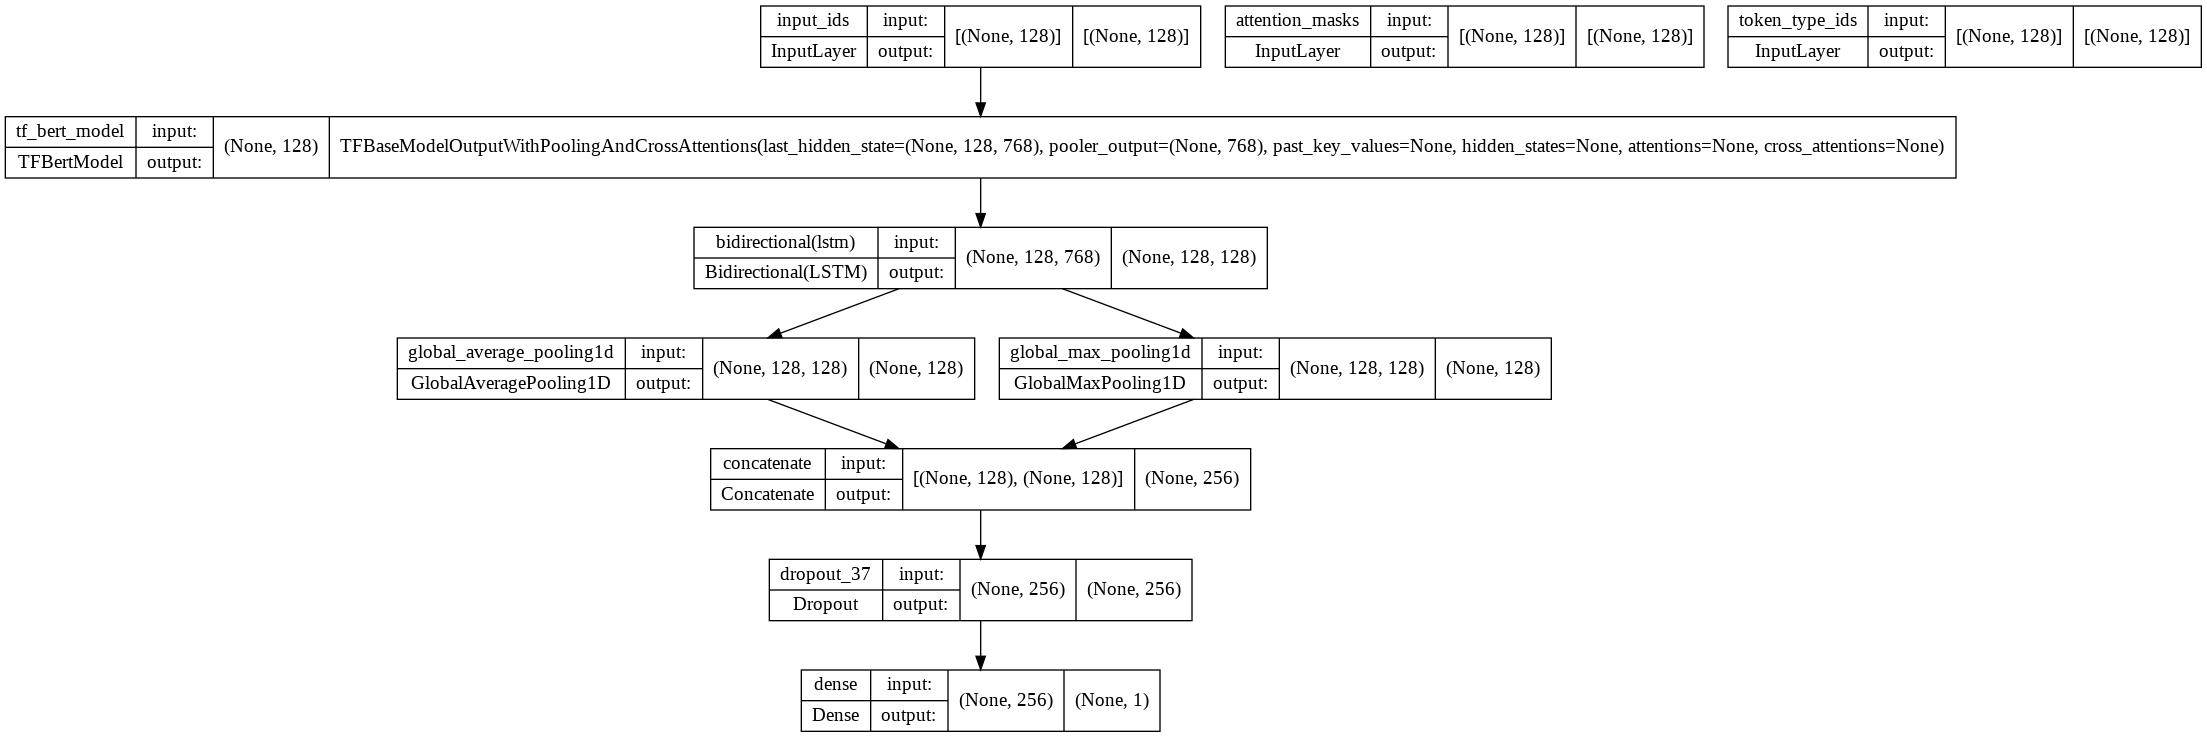

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
test_data_=[test_data['input_ids'],test_data['token_type_ids'],test_data['attention_mask']]
model.evaluate(test_data_,test_y)

20/20 [==============================] - 15s 510ms/step - loss: 0.7086 - acc: 0.6459


[0.7085531949996948, 0.645901620388031]

In [ ]:
model.metrics_names

['loss', 'acc']

In [ ]:
history.history.keys()

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored